# **ДЗ №5 STEM. Алексеев Виталий**

## **0 Импорт библиотек**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from itertools import combinations

np.random.seed(42)

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/Raven-ES1617/cu/refs/heads/main/science_studio/whole_data_practice_4.csv")
df.set_index(["RAJ2000", "DEJ2000"], inplace=True)
df.drop([col for col in df.columns if col.startswith("e_")], axis=1, inplace=True)
df["present"] = pd.Categorical(df["present"])
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 56298 entries, (np.float64(168.580444), np.float64(1.051704)) to (np.float64(124.382068), np.float64(19.629855))
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Vmag     56298 non-null  float64 
 1   Bmag     56298 non-null  float64 
 2   gpmag    56298 non-null  float64 
 3   rpmag    56298 non-null  float64 
 4   ipmag    56298 non-null  float64 
 5   fuv_mag  56298 non-null  float64 
 6   nuv_mag  56298 non-null  float64 
 7   err      56298 non-null  float64 
 8   present  56298 non-null  category
 9   min_mag  56298 non-null  float64 
 10  max_mag  56298 non-null  float64 
dtypes: category(1), float64(10)
memory usage: 9.7 MB


## **Задача 1**

In [4]:
bands = {
    'fuv': 'fuv_mag',
    'nuv': 'nuv_mag',
    'B': 'Bmag',
    'V': 'Vmag',
    'g': 'gpmag',
    'r': 'rpmag',
    'i': 'ipmag'
}

for b1, b2 in combinations(bands.keys(), 2):
    col1, col2 = bands[b1], bands[b2]
    new_col = f"{b1}-{b2}"
    df[new_col] = df[col1] - df[col2]

df["amplitude"] = df["max_mag"] - df["min_mag"]

df.head()

,,Vmag,Bmag,gpmag,rpmag,ipmag,fuv_mag,nuv_mag,err,present,min_mag,...,B-g,B-r,B-i,V-g,V-r,V-i,g-r,g-i,r-i,amplitude
RAJ2000,DEJ2000,,,,,,,,,,,,,,,,,,,,,
168.580444,1.051704,11.143,11.592,13.105,10.993,11.012,18.347,14.734,3.579373,0,13.29,...,-1.513,0.599,0.580,-1.962,0.150,0.131,2.112,2.093,-0.019,0.12
141.300348,3.499374,11.564,12.160,11.716,13.713,11.033,23.511,16.393,2.697571,0,13.29,...,0.444,-1.553,1.127,-0.152,-2.149,0.531,-1.997,0.683,2.680,0.12
129.795551,18.175921,10.179,10.731,11.355,10.829,10.018,20.863,14.930,2.676753,0,13.29,...,-0.624,-0.098,0.713,-1.176,-0.650,0.161,0.526,1.337,0.811,0.12
118.424259,21.332130,11.203,11.553,11.374,11.141,12.418,18.715,14.744,2.616093,0,13.29,...,0.179,0.412,-0.865,-0.171,0.062,-1.215,0.233,-1.044,-1.277,0.12
62.954121,-5.236932,10.699,11.382,11.896,10.502,10.418,22.283,15.858,2.570908,0,13.29,...,-0.514,0.880,0.964,-1.197,0.197,0.281,1.394,1.478,0.084,0.12


Доля в выборке:
	0 - 0.8950229137802409
	1 - 0.10497708621975914


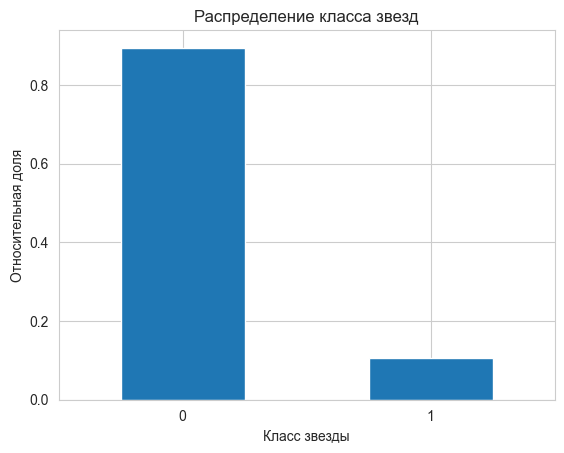

In [10]:
(df["present"].value_counts() / len(df)).plot(
    kind="bar",
    title="Распределение класса звезд",
    xlabel="Класс звезды",
    ylabel="Относительная доля",
    rot=0
)
present_0_frac, present_1_frac = df["present"].value_counts() / len(df)
print(f"Доля в выборке:\n\t0 - {present_0_frac}\n\t1 - {present_1_frac}")

Очевидно, что класс "0" (непеременные звезды) сильно доминирует над классом "1" (переменные). В контексте деревьев решений такое соотношение ($\approx 9:1$) катастрофически много, в частности это ведет к:
1. Ухудшению общей метрики модели: дерево воспринимает неправильно определенные объекты как "приемлемую" статистическую погрешность, как итого имеем огромное количество $FN$-результатов.
2. Потеря огроиного числа переменных звезд и (что более важно с точки зрения научного изыскания) возможных переменных звезд ($TF$) в процессе классификации.

## **Задача 2**

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

X = df.drop("present", axis=1).copy()
Y = df["present"]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, stratify=df["present"], random_state=42
)

param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 5, 10]
}

In [13]:
tree_basic_A = RandomForestClassifier(random_state=42, class_weight='balanced')
model_A = GridSearchCV(tree_basic_A, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
model_A.fit(X_train, y_train)

print(classification_report(y_test, model_A.predict(X_test)))
print("Balanced Accuracy (A):", balanced_accuracy_score(y_test, model_A.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     12597
           1       0.83      0.28      0.42      1478

    accuracy                           0.92     14075
   macro avg       0.88      0.64      0.69     14075
weighted avg       0.91      0.92      0.90     14075

Balanced Accuracy (default model): 0.6390483729882633


- `accuracy` уменьшилась с $0,92$ до $0,88$ ($\approx -4,3\%$)
- `balanced accuracy` увеличилась с $0,64$ до $0,82$ ($+\approx 28,1\%$)
- `precision` уменьшился с $0,83$ до $0,45$ ($\approx -45,8 \%$)
- `recall` увеличился с $0,29$ до $0,75$ ($\approx +158,6 \%$)
- `f1-score` увеличился с $0,44$ до $0,56$ ($\approx + 27,3 \%$)

In [12]:
X_majority = X_train[y_train == 0]
X_minority = X_train[y_train == 1]

y_majority = y_train[y_train == 0]
y_minority = y_train[y_train == 1]

X_majority_downsampled, y_majority_downsampled = resample(
    X_majority, y_majority,
    replace=False,
    n_samples=len(y_minority),
    random_state=42
)

X_train_balanced = pd.concat([X_majority_downsampled, X_minority])
y_train_balanced = pd.concat([y_majority_downsampled, y_minority])

tree_basic_B = RandomForestClassifier(random_state=42)
model_B = GridSearchCV(tree_basic_B, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
model_B.fit(X_train_balanced, y_train_balanced)

print(classification_report(y_test, model_B.predict(X_test)))
print("Balanced Accuracy (B):", balanced_accuracy_score(y_test, model_B.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     12597
           1       0.37      0.85      0.51      1478

    accuracy                           0.83     14075
   macro avg       0.67      0.84      0.71     14075
weighted avg       0.92      0.83      0.86     14075

Balanced Accuracy (B): 0.8402391488060768


- `accuraccy` уменьшился с $0,92$ до $0,83$ ($\approx -9,8\%$)
- `balanced accuracy` увеличился с $0,64$ до $0,84$ ($\approx +31,3\%$)
- `precision` уменьшился с $0,83$ до $0,37$ ($\approx -55,4\%$)
- `recall` увеличился с $0,29$ до $0,85$ ($\approx +193,3\%$)
- `f1-score` увеличился с $0,44$ до $0,51$ ($\approx +15,9\%$)

Как можно заметить, андерсемплинг достаточно хорошо увечил сбалансированную точность, однако точность определения класса 1, наоборот, снизилась, т.е. мы потеряли примерно $1/10$ переменных звезд, что весьма много.

Такой эффект достигается вследствие того, что дерево решений может более точно разделить два класса, поскольку кол-во элементов в кажом примерно одинаково, как раз-таки из-за этого и снизилась точность определения класса 1, поскольку алгоритм считает, что оба класса встречаются примерно равное кол-во раз.

## **Задача 3**

In [11]:
from imblearn.ensemble import BalancedRandomForestClassifier

tree_basic_C = BalancedRandomForestClassifier(random_state=42, class_weight='balanced')
model_C = GridSearchCV(tree_basic_C, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
model_C.fit(X_train, y_train)

print(classification_report(y_test, model_C.predict(X_test)))
print("Balanced Accuracy (C):", balanced_accuracy_score(y_test, model_C.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.48      0.65     12597
           1       0.18      0.98      0.31      1478

    accuracy                           0.54     14075
   macro avg       0.59      0.73      0.48     14075
weighted avg       0.91      0.54      0.61     14075

Balanced Accuracy (C): 0.733068385270759


При отбрасывании определенных данных из датасета есть огромная вероятность отбросить достаточно важные (с точки зрения научного исследования, опять же) данные, кроме того данных может быть настолько мало, что исключение некоторой части приведет к кратному ухудшению качества модели ввиду ее недообучения.

## **Задача 4**

In [14]:
tree_basic = RandomForestClassifier(random_state=42)
default_model = GridSearchCV(tree_basic, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
default_model.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     12597
           1       0.83      0.28      0.42      1478

    accuracy                           0.92     14075
   macro avg       0.88      0.64      0.69     14075
weighted avg       0.91      0.92      0.90     14075

Balanced Accuracy (default model): 0.6390483729882633


,accuracy,balanced_accuracy,precision_minor,recall_minor,f1_minor,precision_major,recall_major,f1_major
balanced RF,0.878508,0.820449,0.452459,0.746955,0.563553,0.967856,0.893943,0.929432
undersampled RF,0.830551,0.840239,0.367669,0.852503,0.513761,0.979527,0.827975,0.897397
default RF,0.918863,0.639048,0.832016,0.284844,0.424395,0.922102,0.993252,0.956356


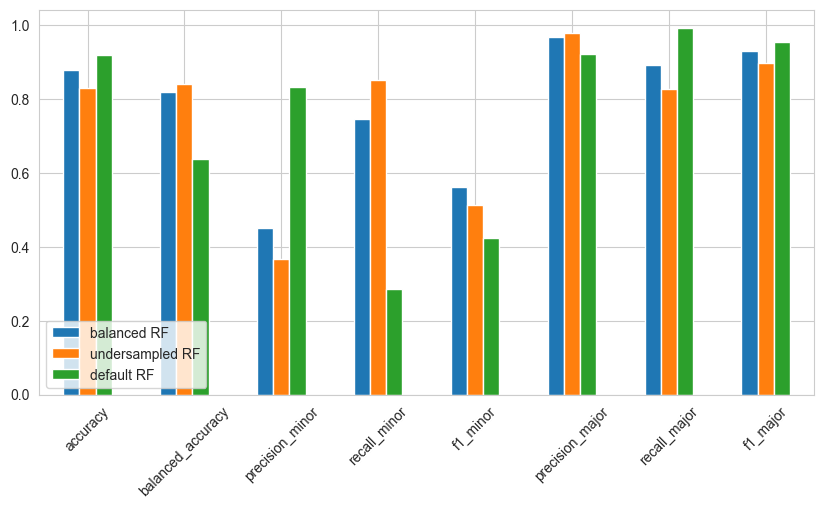

In [43]:
def get_classification_info(model: GridSearchCV):
    report: dict[str, dict[str, float]] = classification_report(
        y_test, model.predict(X_test), output_dict=True
    )
    result = dict()
    result["accuracy"] = report["accuracy"]
    result["balanced_accuracy"] = balanced_accuracy_score(y_test, model.predict(X_test))

    result["precision_minor"] = report["1"]["precision"]
    result["recall_minor"] = report["1"]["recall"]
    result["f1_minor"] = report["1"]["f1-score"]

    result["precision_major"] = report["0"]["precision"]
    result["recall_major"] = report["0"]["recall"]
    result["f1_major"] = report["0"]["f1-score"]

    return result

models = {model_A: "balanced RF", model_B: "undersampled RF", default_model: "default RF"}

models_stats = pd.DataFrame(
    {models[model]: get_classification_info(model) for model in models}
)
display(models_stats.T)
models_stats.plot(kind="bar", figsize=(10, 5), rot=45)
plt.legend(loc="lower left")
plt.show()

Лучший `recall` для малого класса показывает андерсемплинг, но, как и было сказано ранее, достигается это уменьшением общего числа данных, что ведет к снижению общей точности.

`class_weight` уместен в тех ситуациях, когда данных либо мало, либо они неоднородны: извлечение части из них влечет за собой значительные изменения в самой модели. В остальных случаях можно сказать, что данные пропорциональны, поэтому данные сверх числа объектов малого класса лишь дублируют информацию, а не привносят новые знания о модели.

Из бар-чарта видно, что явного лидера выделить нельзя: в каждом признаке есть свой лидер.

## **Задача 5**

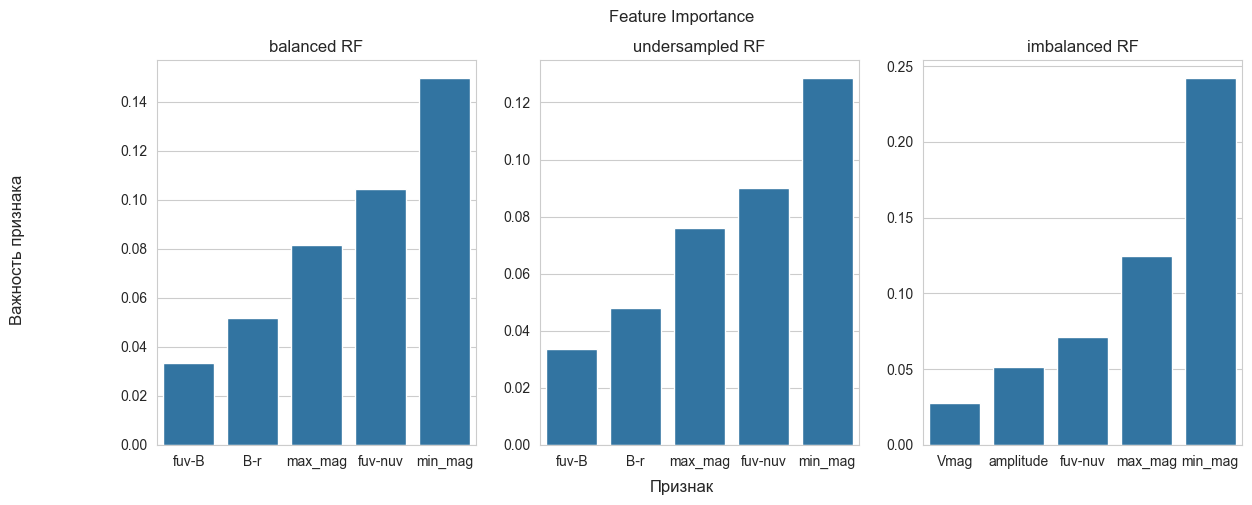

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

models = {model_A: "balanced RF", model_B: "undersampled RF", model_C: "imbalanced RF"}
for i, model in enumerate(models):
    importances = model.best_estimator_.feature_importances_
    features = X_train.columns

    indices = np.argsort(importances)[::-1]

    top5_features = features[indices[:5]]
    top5_importances = importances[indices[:5]]

    sns.barplot(x=top5_features[::-1], y=top5_importances[::-1], ax=axes[i])
    axes[i].set_title(models[model])
    axes[i].set_xlabel("")

fig.supxlabel("Признак")
fig.supylabel("Важность признака")
fig.suptitle("Feature Importance")
plt.show()

Как видно из графиков, порядок меняется, однако есть некоторые величины, чье положение остается неизменным: `min_mag`, в тройку неизменных лидеров так же входят `max_mag` и `fuv_nuv`.

Чем более данные вмешаны, тем больше алгоритм полагается не на меняющиеся физические величины, а на постоянные статистические (цветовой пояс vs максимальная звездная величина), объясняется это тем, что наиболее устойчивый к такому роду выбросов является именно статистические величины, поскольку именно они, как правило, имеют определенное хорошо описываемое распределение (нормальное).